In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import random 
import scipy as sc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import stormeunice as eun

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

# Import data

In [2]:
lon_min = -15
lon_max = 5
lat_min = 45
lat_max = 60

In [3]:
# ERA5

era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc')
era5_GUST = era5_2022.fg10.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='3h').max().load()
era5_PRES = era5_2022.msl.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='3h').max().load()

In [4]:
# EPS
inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
experiments = ['pi', 'curr', 'incr']
eps = {}
for inidate in inidates:
    eps[inidate] = eun.data.Data.get_eps_data(experiments, inidate = inidate)

/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nq_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2nq_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2nr_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2nr_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nn_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2nn_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2no_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2no_2022-02-14

# Select extreme and weak ensemble members

In [5]:
# box for selecting max wind gusts
full_map = [lon_min, lon_max, lat_min, lat_max]
fg10_box = full_map.copy()  #[-7, 2, 49, 54]  # lon_min, lon_max, lat_min, lat_max

In [6]:
members = {'extreme': [],
           'weak': []}
eps_extreme = []
eps_weak = []

eps_extreme_dict = {}

for inidate in inidates:
    # Store data in dictionary for readability
    eps_extreme_dict[inidate] = {}
    for experiment in experiments:

        # select all time steps on the 18th but explicitly not just one to account for different peak times
        eps_feb18 = eps[inidate][experiment].sel(time='2022-02-18').sel(latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).squeeze()

        # select wind gusts within the boxes for each ensemble member
        eps_boxwinds = eps_feb18.sel(latitude=slice(fg10_box[3],fg10_box[2]),longitude=slice(fg10_box[0], fg10_box[1])).fg10.squeeze()

        # calculate 95th percentile for each member wtihin the box
        fg10_95 = eps_boxwinds.quantile(0.95, dim = ['latitude', 'longitude', 'time'])

        # select extreme and weak members based on being among the 10 strongest wind members 
        extremes = []
        for number in range(0,51):
            if (number in fg10_95.sortby(fg10_95).number.values[-10:]):
                extremes.append('wind')
            else:
                extremes.append('none')
        
        extreme_members = pd.DataFrame(data = {'number':list(range(0,51)), 'fg10_95':fg10_95.values, 'extremes': extremes})
        members['extreme'].append(extreme_members[(extreme_members['extremes'].isin(['wind']))].number.values)
        eps_extreme_dict[inidate][experiment] = (eps[inidate][experiment].sel(number = members['extreme'][-1]).squeeze())

# Significance testing

In [7]:
# Calculate significance for pi and incr maps
sign_test = {}
for inidate in inidates:
    comp = eps_extreme_dict[inidate]['curr'].sel(time = slice('2022-02-18 00', '2022-02-18 23')).fg10.max(dim = ["time"]).mean('number')
    sign_test[inidate] = {}
    for exp in ['pi', 'incr']:
        map = eps_extreme_dict[inidate][exp].sel(time = slice('2022-02-18 00', '2022-02-18 23')).fg10.max(dim = ["time"])
        sign_test[inidate][exp] = xr.DataArray(sc.stats.binom(10, 0.5).cdf((map>comp).sum('number')))

# Compositing

In [8]:
# Calculate maximum gusts and minimum pressure fields across extreme composite
maximum_gusts_eps = {}
minimum_pres_eps = {}
mean_pres_eps = {}
for inidate in inidates:
    maximum_gusts_eps[inidate] = {key:value.sel(time = slice('2022-02-18 00', '2022-02-18 23')).fg10.max(dim = ["time"]).mean(dim = "number") for (key,value) in eps_extreme_dict[inidate].items()}
    minimum_pres_eps[inidate] = {key:value.sel(time = slice('2022-02-18 00', '2022-02-18 23')).msl.min(dim = ["time"]).mean(dim = "number") for (key,value) in eps_extreme_dict[inidate].items()}
    mean_pres_eps[inidate] = {key:value.sel(time = '2022-02-18 12').msl.mean(dim = "number") for (key,value) in eps_extreme_dict[inidate].items()}

In [9]:
maximum_gusts_era5 = era5_GUST.sel(time = slice('2022-02-18 00', '2022-02-18 23')).max(dim = ["time"])
minimum_pres_era5 = era5_PRES.sel(time = slice('2022-02-18 00', '2022-02-18 23')).min(dim = ["time"])
mean_pres_era5 = era5_PRES.sel(time = '2022-02-18 12')

In [10]:
euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]

# Plotting

/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'n_levels', 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


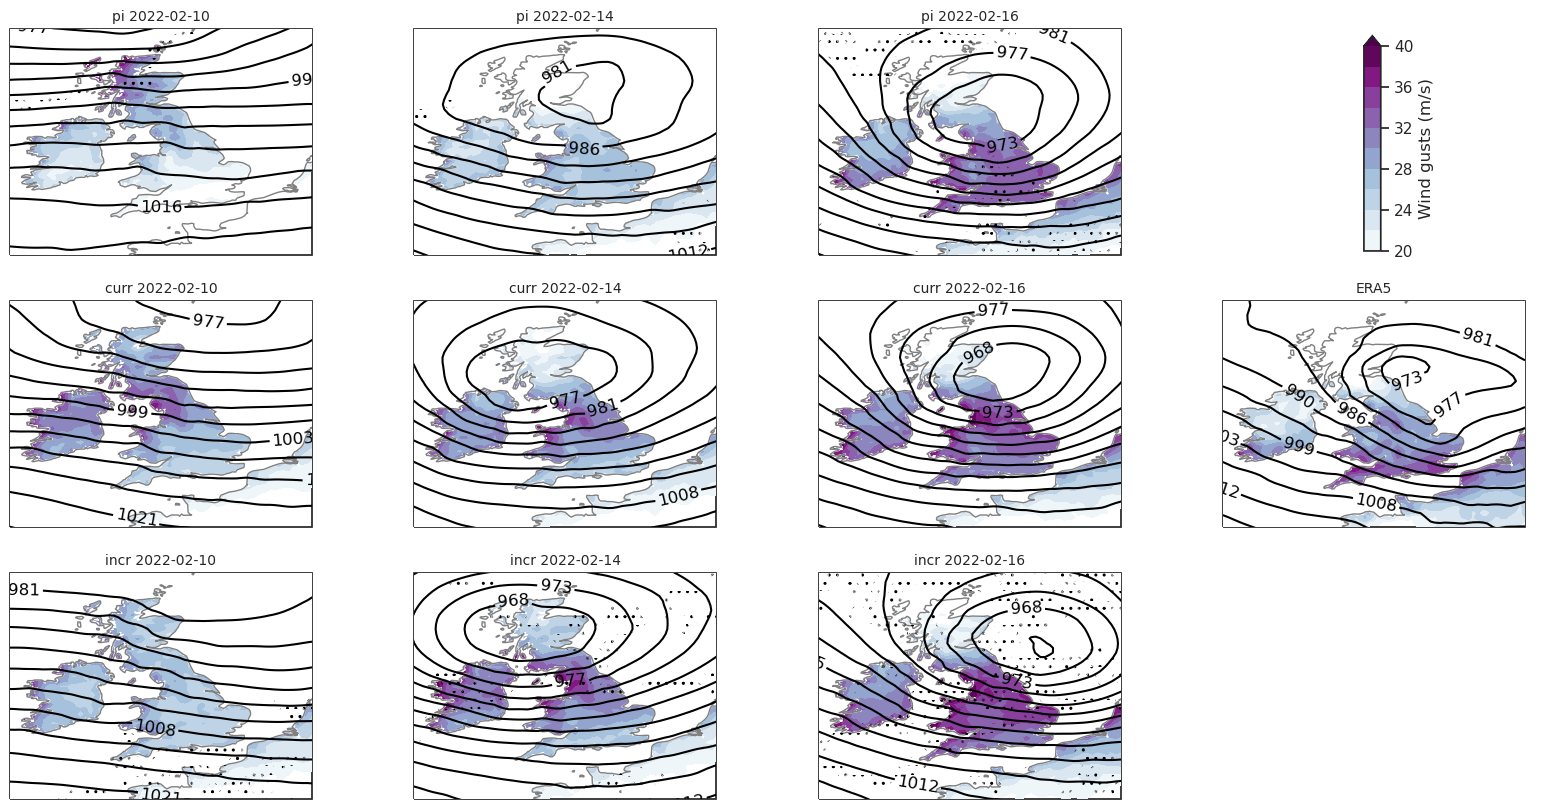

In [11]:
# figure and map setup
projection = ccrs.PlateCarree()
p_max = 1030
p_min = 960

fg10_min = 20
fg10_max = 40

fig = plt.figure(1, figsize=(20, 10))

# EPS data ------------------    
latitude = mean_pres_eps['2022-02-10']['pi'].latitude
longitude = mean_pres_eps['2022-02-10']['pi'].longitude

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        p_vals = mean_pres_eps[inidate][experiment].values/100
        fg10_vals = maximum_gusts_eps[inidate][experiment].values

        ax = plt.subplot(3,4, i+1+e*4,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # # fg10 as shading
        clevs_fg10 = np.linspace(fg10_min, fg10_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                        transform=projection, zorder = 10, extend = 'max')
        
        # isobars as contours
        clevs_p = np.linspace(p_min, p_max, 17) 
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d')
        ax.set_title(experiment+' '+inidate, size = '10')
    
        # hatching for significance
        if experiment in ['pi', 'incr']:
            sign = sign_test[inidate][experiment]>0.9
            ax.contourf(longitude, latitude, sign, alpha=0,hatches=[None, '..'], n_levels=2, add_colorbar=False, zorder=15)

# ERA5 data ----------------------
latitude = mean_pres_era5.latitude
longitude = mean_pres_era5.longitude

p_vals = mean_pres_era5.values/100
fg10_vals = maximum_gusts_era5.values
ax = plt.subplot(3,4,8,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

# fg10 as shading
clevs_fg10 = np.linspace(fg10_min, fg10_max, 11)  # 17
cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 17) 
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d')
ax.set_title("ERA5", size = 10)


# Other figure settings -----------------
ax = plt.subplot(3,4,4)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.47, 0.02, 0.05, 0.95])  # creates inset, [x0,y0, width, height]
fig.colorbar(cf, cax=cax, label='Wind gusts (m/s)', extend = 'max', shrink=0.8)

plt.savefig('figures/PAPER1_max_gusts'+inidate+'.png')
plt.savefig('figures/PAPER1_max_gusts'+inidate+'.pdf')

/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'n_levels', 'add_colorbar'
  result = super().contourf(*args, **kwargs)


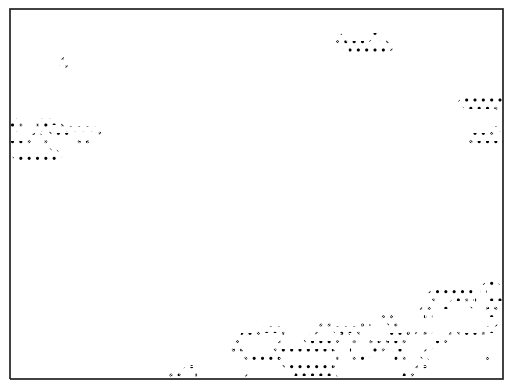

In [28]:
latitude = mean_pres_eps['2022-02-10']['pi'].latitude
longitude = mean_pres_eps['2022-02-10']['pi'].longitude
inidate = '2022-02-14'
experiment = 'pi'

fig = plt.figure(1)
sign = sign_test[inidate][experiment]>0.8
ax = plt.subplot(1,1, 1, projection = projection)
ax.set_extent(uk, projection)
plt.contourf(longitude, latitude, sign,alpha = 0, hatches=[None, '..'], n_levels=2, add_colorbar=False, zorder=15, transform=projection)